import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from keras.preprocessing import image
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import time

2023-05-04 17:07:30.537293: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 17:07:31.952738: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 17:07:31.959825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 17:07:37.876054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


functions

In [2]:
SAVED_MODEL_BEST_ACCURACY_RESULTS = []
SAVED_MODEL_BEST_LOSS_RESULTS = []
EPOCHS = 30

In [3]:
def transform(data):
    data = utils.load_img(data, color_mode='grayscale', target_size=(64, 64))
    data = utils.img_to_array(data)
    data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [4]:
def get_examples_and_classes(dataset_dir, num):
    classes = sorted(os.listdir(dataset_dir))
    examples = []
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        examples.append(os.path.join(class_dir, images[num]))

    return classes, examples

In [5]:
def plot(accuracy, loss, val_accuracy, val_loss):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')

    ax1.set_ylabel('total loss')
    ax1.plot(loss,color='tab:red')
    ax1.plot( val_loss, color='tab:brown')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy')  
    ax2.plot( accuracy, color='tab:blue')
    ax2.plot( val_accuracy, color='tab:green')
    ax2.tick_params(axis='y')
    fig.tight_layout()

In [6]:
def plot_many(title='title', data=[]):
    for i,o in enumerate(data):
        plt.figure(i)
        plt.plot([i for i in range(EPOCHS)],o, label=title)
        plt.legend(loc='upper left')

In [7]:
def max_or_min(list_of_data, accuracy=True):
    dict_all_l = {}
    for i, o in enumerate(list_of_data):
        dict_all_l[i] = sum(o)/len(o)
    if accuracy:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1], reverse=True))
    else:
        return dict(sorted(dict_all_l.items(), key=lambda item: item[1]))

In [8]:
def save_lists():
    t = time.ctime(time.time())[:-5]
    with open(f'accuracy {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_ACCURACY_RESULTS:
            f.write("%s\n" % item)
    with open(f'loss {t}.txt', 'w') as f:
        for item in SAVED_MODEL_BEST_LOSS_RESULTS:
            f.write("%s\n" % item)

In [9]:
def read_list_from_file(filename):
    lst = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            line = line[1:-2].split(', ')
            lst.append([float(i.strip()) for i in line])
    return lst

dataset

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_folder = "/home/jovyan/dataset/dataset2/train"
test_folder = "/home/jovyan/dataset/dataset2/test"

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 color_mode='grayscale')

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            color_mode='grayscale')

Found 22734 images belonging to 164 classes.
Found 5678 images belonging to 164 classes.


model

In [11]:
def model(in_1=8, in_2=8, in_3=8, in_4=8):
    model = Sequential()
    model.add(Conv2D(filters=in_1,kernel_size=2, strides=(1,1), input_shape=(64,64,1), padding='valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters=in_2,kernel_size=2, strides=1, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters=in_3,kernel_size=2, strides=1, padding ='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # model.add(Conv2D(filters=in_4,kernel_size=2, strides=1, padding ='same', activation = 'relu'))
    # model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dense(units = 512 , activation = 'tanh'))
    model.add(Dense(units = 164 , activation = 'softmax'))

    model.compile( optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

    return model
# summary_example = model()
# summary_example.summary()

choose best hyperparameters

In [12]:
def model_and_best_hyperparameters():
    nums = [8,16, 32, 64, 128]
    start_time1 = time.time()
    for i in nums:        
        start_time2 = time.time()
        
        ready_model = model(i,i*2,i*3, i*4)        
        trained_model = ready_model.fit(training_set, steps_per_epoch = 32, epochs = EPOCHS, validation_data = test_set)
        
        end_time2 = time.time()
        print("for one training time taken: {:.2f} seconds".format(end_time2 - start_time2))
        
        accuracy = trained_model.history['accuracy']
        loss = trained_model.history['loss']
    
        SAVED_MODEL_BEST_ACCURACY_RESULTS.append(accuracy)
        SAVED_MODEL_BEST_LOSS_RESULTS.append(loss)
        
    end_time1 = time.time()
    print("for all training time taken: {:.2f} seconds".format(end_time1 - start_time1))

In [13]:
model_and_best_hyperparameters()

Epoch 1/30


2023-05-04 17:07:42.305207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


31/32 [============================>.] - ETA: 0s - loss: 5.1224 - accuracy: 0.0091

2023-05-04 17:07:44.789527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 6s 160ms/step - loss: 5.1217 - accuracy: 0.0088 - val_loss: 5.0939 - val_accuracy: 0.0067
Epoch 2/30
32/32 [==============================] - 5s 163ms/step - loss: 5.0934 - accuracy: 0.0029 - val_loss: 5.0826 - val_accuracy: 0.0114
Epoch 3/30
32/32 [==============================] - 5s 159ms/step - loss: 5.0790 - accuracy: 0.0088 - val_loss: 5.0576 - val_accuracy: 0.0176
Epoch 4/30
32/32 [==============================] - 5s 155ms/step - loss: 5.0512 - accuracy: 0.0078 - val_loss: 5.0077 - val_accuracy: 0.0155
Epoch 5/30
32/32 [==============================] - 5s 155ms/step - loss: 4.9981 - accuracy: 0.0127 - val_loss: 4.9627 - val_accuracy: 0.0146
Epoch 6/30
32/32 [==============================] - 5s 155ms/step - loss: 4.9537 - accuracy: 0.0146 - val_loss: 4.9085 - val_accuracy: 0.0269
Epoch 7/30
32/32 [==============================] - 5s 163ms/step - loss: 4.8907 - accuracy: 0.0205 - val_loss: 4.8471 - val_accuracy: 0.0248
Epoch 8/30
32/32 

2023-05-04 17:10:15.452160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.1256 - accuracy: 0.0078

2023-05-04 17:10:18.544421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 7s 214ms/step - loss: 5.1256 - accuracy: 0.0078 - val_loss: 5.0955 - val_accuracy: 0.0122
Epoch 2/30
32/32 [==============================] - 6s 202ms/step - loss: 5.0939 - accuracy: 0.0098 - val_loss: 5.0814 - val_accuracy: 0.0167
Epoch 3/30
32/32 [==============================] - 6s 197ms/step - loss: 5.0711 - accuracy: 0.0050 - val_loss: 5.0448 - val_accuracy: 0.0132
Epoch 4/30
32/32 [==============================] - 6s 195ms/step - loss: 5.0380 - accuracy: 0.0186 - val_loss: 5.0138 - val_accuracy: 0.0166
Epoch 5/30
32/32 [==============================] - 6s 195ms/step - loss: 4.9742 - accuracy: 0.0234 - val_loss: 4.9571 - val_accuracy: 0.0231
Epoch 6/30
32/32 [==============================] - 6s 194ms/step - loss: 4.9287 - accuracy: 0.0225 - val_loss: 4.9158 - val_accuracy: 0.0294
Epoch 7/30
32/32 [==============================] - 6s 197ms/step - loss: 4.8936 - accuracy: 0.0225 - val_loss: 4.8140 - val_accuracy: 0.0350
Epoch 8/30
32/32 

2023-05-04 17:13:01.116585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.1123 - accuracy: 0.0068

2023-05-04 17:13:05.065353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 9s 249ms/step - loss: 5.1123 - accuracy: 0.0068 - val_loss: 5.0944 - val_accuracy: 0.0090
Epoch 2/30
32/32 [==============================] - 8s 245ms/step - loss: 5.0891 - accuracy: 0.0059 - val_loss: 5.0752 - val_accuracy: 0.0148
Epoch 3/30
32/32 [==============================] - 8s 250ms/step - loss: 5.0639 - accuracy: 0.0156 - val_loss: 5.0359 - val_accuracy: 0.0164
Epoch 4/30
32/32 [==============================] - 8s 244ms/step - loss: 5.0176 - accuracy: 0.0264 - val_loss: 5.0087 - val_accuracy: 0.0222
Epoch 5/30
32/32 [==============================] - 8s 245ms/step - loss: 4.9516 - accuracy: 0.0137 - val_loss: 4.9321 - val_accuracy: 0.0192
Epoch 6/30
32/32 [==============================] - 8s 245ms/step - loss: 4.8944 - accuracy: 0.0225 - val_loss: 4.8712 - val_accuracy: 0.0275
Epoch 7/30
32/32 [==============================] - 8s 248ms/step - loss: 4.8230 - accuracy: 0.0312 - val_loss: 4.7758 - val_accuracy: 0.0322
Epoch 8/30
32/32 

2023-05-04 17:16:55.167967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - ETA: 0s - loss: 5.1116 - accuracy: 0.0107

2023-05-04 17:17:02.732466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 16s 493ms/step - loss: 5.1116 - accuracy: 0.0107 - val_loss: 5.0981 - val_accuracy: 0.0069
Epoch 2/30
32/32 [==============================] - 15s 478ms/step - loss: 5.0970 - accuracy: 0.0088 - val_loss: 5.0851 - val_accuracy: 0.0097
Epoch 3/30
32/32 [==============================] - 15s 483ms/step - loss: 5.0686 - accuracy: 0.0098 - val_loss: 5.0719 - val_accuracy: 0.0125
Epoch 4/30
32/32 [==============================] - 15s 481ms/step - loss: 5.0397 - accuracy: 0.0146 - val_loss: 5.0013 - val_accuracy: 0.0173
Epoch 5/30
32/32 [==============================] - 15s 479ms/step - loss: 5.0113 - accuracy: 0.0137 - val_loss: 4.9358 - val_accuracy: 0.0217
Epoch 6/30
32/32 [==============================] - 15s 478ms/step - loss: 4.9335 - accuracy: 0.0205 - val_loss: 4.8671 - val_accuracy: 0.0324
Epoch 7/30
32/32 [==============================] - 15s 476ms/step - loss: 4.8775 - accuracy: 0.0225 - val_loss: 4.7997 - val_accuracy: 0.0377
Epoch 8/30

2023-05-04 17:24:29.270614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-04 17:24:29.965836: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


 1/32 [..............................] - ETA: 40s - loss: 5.0920 - accuracy: 0.0312

2023-05-04 17:24:30.493977: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2023-05-04 17:24:30.579566: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


 2/32 [>.............................] - ETA: 17s - loss: 5.2118 - accuracy: 0.0156

2023-05-04 17:24:31.069305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2023-05-04 17:24:31.176185: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


32/32 [==============================] - ETA: 0s - loss: 5.1167 - accuracy: 0.0068

2023-05-04 17:24:47.360674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 38s 1s/step - loss: 5.1167 - accuracy: 0.0068 - val_loss: 5.0991 - val_accuracy: 0.0077
Epoch 2/30
32/32 [==============================] - 36s 1s/step - loss: 5.0977 - accuracy: 0.0098 - val_loss: 5.0913 - val_accuracy: 0.0085
Epoch 3/30
32/32 [==============================] - 36s 1s/step - loss: 5.0692 - accuracy: 0.0117 - val_loss: 5.0719 - val_accuracy: 0.0122
Epoch 4/30
32/32 [==============================] - 36s 1s/step - loss: 5.0538 - accuracy: 0.0098 - val_loss: 5.0296 - val_accuracy: 0.0088
Epoch 5/30
32/32 [==============================] - 36s 1s/step - loss: 5.0245 - accuracy: 0.0088 - val_loss: 5.0283 - val_accuracy: 0.0118
Epoch 6/30
32/32 [==============================] - 36s 1s/step - loss: 5.0031 - accuracy: 0.0189 - val_loss: 4.9804 - val_accuracy: 0.0178
Epoch 7/30
32/32 [==============================] - 36s 1s/step - loss: 4.9643 - accuracy: 0.0176 - val_loss: 4.9389 - val_accuracy: 0.0201
Epoch 8/30
32/32 [=============

In [14]:
print("sorted list of average  epochs' values for accuracy  ", max_or_min(SAVED_MODEL_BEST_ACCURACY_RESULTS))
print("sorted list of average  epochs' values for loss  ", max_or_min(SAVED_MODEL_BEST_LOSS_RESULTS, False))
save_lists()

sorted list of average  epochs' values for accuracy   {3: 0.06443817565838496, 2: 0.063671875, 1: 0.06006150596464674, 4: 0.05547981640944878, 0: 0.055078125}
sorted list of average  epochs' values for loss   {3: 4.546154308319092, 2: 4.553190612792969, 1: 4.577251561482748, 4: 4.619519265492757, 0: 4.619863589604695}


train and save model

In [15]:
def final_model():
    ready_model = model(8,16,64)
    call_back = ModelCheckpoint(f"/home/jovyan/weights.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    trained_model = model.fit(training_set, steps_per_epoch = 32, epochs = 30, validation_data = test_set, callbacks = [call_back])
    return trained_model


In [16]:
# trained_model = final_model()

plot model

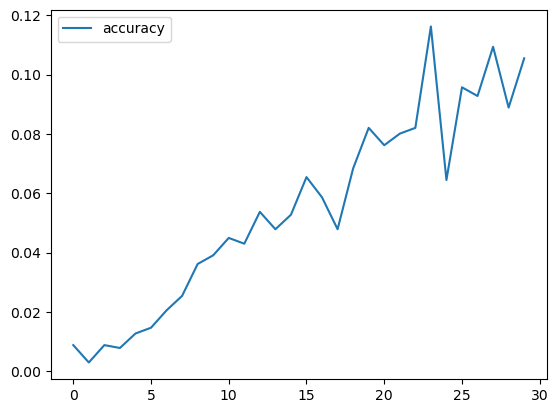

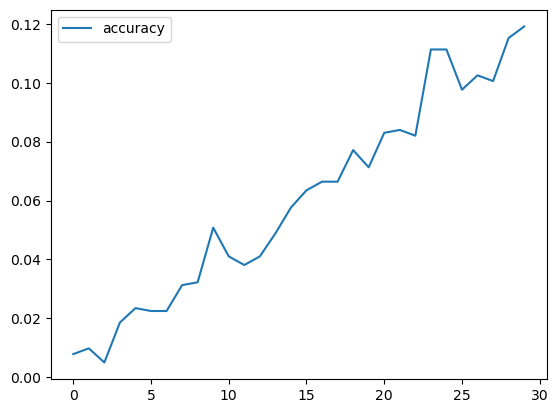

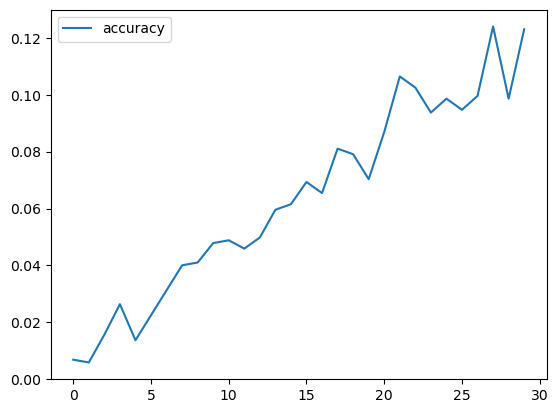

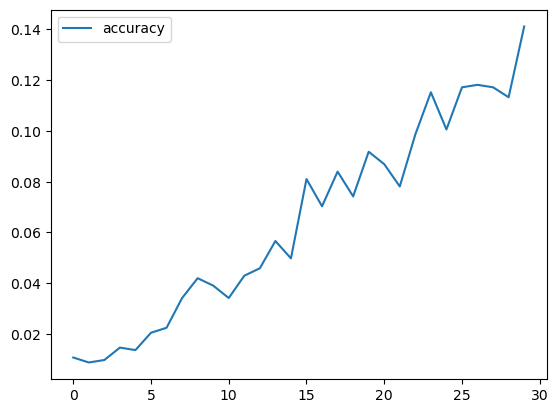

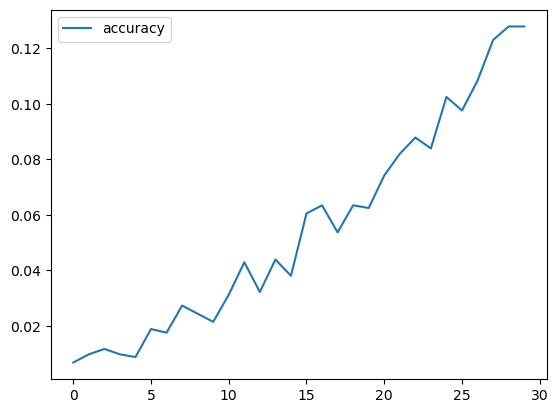

In [17]:
plot_many('accuracy', SAVED_MODEL_BEST_ACCURACY_RESULTS)


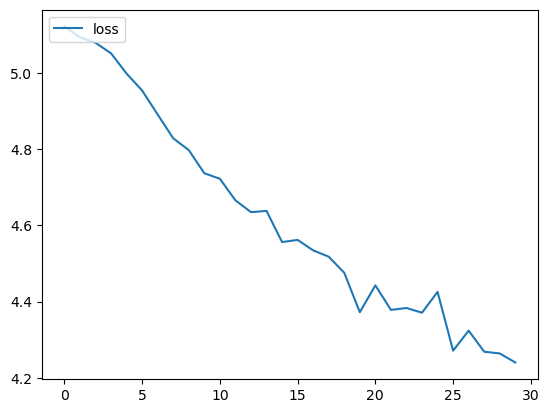

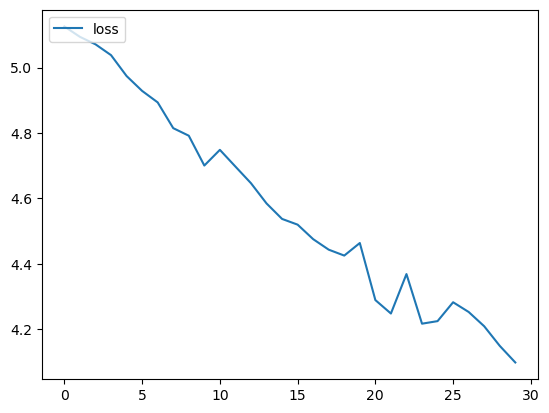

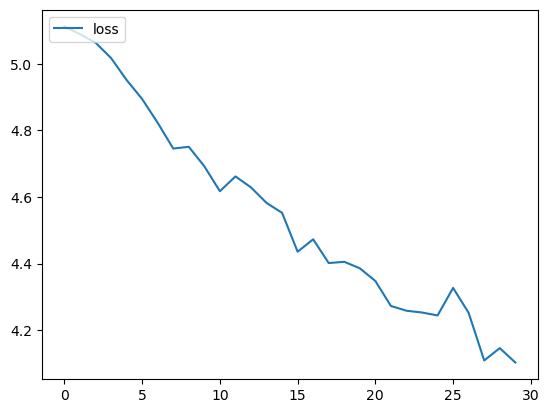

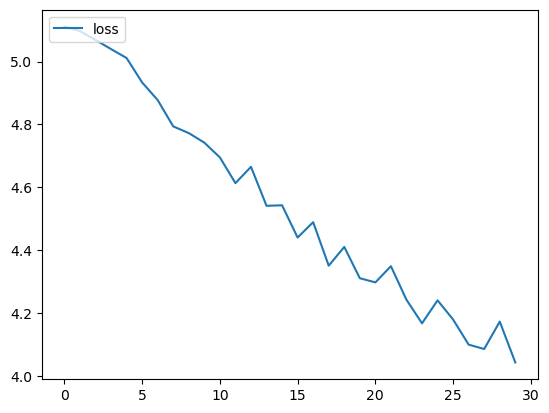

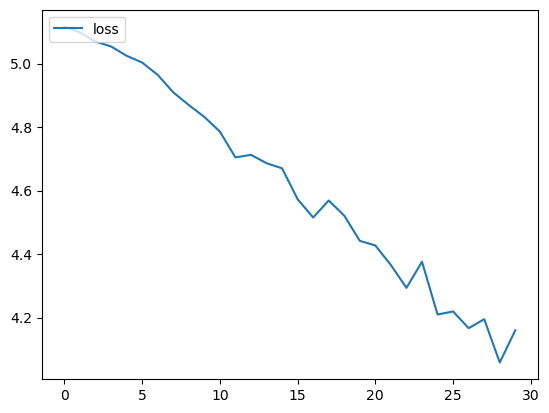

In [18]:
plot_many('loss', SAVED_MODEL_BEST_LOSS_RESULTS)


In [19]:
if trained_model:
    plot(trained_model.history['accuracy'], trained_model.history['loss'], trained_model.history['val_accuracy'], trained_model.history['val_loss'])

NameError: name 'trained_model' is not defined

predict

In [ ]:
predict_model = Sequential()
for layer in model.layers[:-1]:
    predict_model.add(layer)
predict_model.add(Dense(units=1, activation=None))
predict_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
predict_model.summary()


predict_model.load_weights('weights.hdf5', skip_mismatch=True, by_name=True)

# # Load weights and biases from model manually
# for i in range(len(predict_model.layers) - 1):
#     predict_model.layers[i].set_weights(model.layers[i].get_weights())


In [ ]:
def predict(model, known_data_path, unknown_data_path):
    known_data = transform(known_data_path)
    unknown_data = transform(unknown_data_path)

    known_data = model.predict(known_data)
    unknown_data = model.predict(unknown_data)
    distance = unknown_data - known_data

    threshold = 0.018614814
    return  distance[0][0] > threshold, distance[0][0]

predict(predict_model, '/home/jovyan/11.jpg', '/home/jovyan/21.jpg')

plot prediction

In [ ]:
classes, examples1 = get_examples_and_classes(test_folder,1)
classes, examples2 = get_examples_and_classes(test_folder,2)
y_true = [i for i in range(len(classes))]
y_predict_tensors = []
y_predict_labels = []

for i in range(len(classes)):
    predict_label, predict_tensor = predict(predict_model, examples1[i], examples2[i])
    y_predict_tensors.append(predict_tensor)
    y_predict_labels.append(predict_label)    

In [ ]:
print(classification_report(y_true, y_predict_labels, target_names=classes))

choose best threshold

In [ ]:
thresholds = np.linspace(0.0001, 0.5, 1000)

# Calculate F1 score for each threshold
f1_scores = []
for threshold in thresholds:
    y_pred = (y_predict_tensors < threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred, average='micro'))

# Choose the threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_threshold